# Direct Optimization through Argmax  for Discrete Variational Auto-Encoder 

Real-world data is often complex and high-dimensional. A *Generative model* should be able to find the underlying features e.g. interesting patterns, clusters, statistical correlations and causal structures of the data and generate data like it. These underlying features (also called *latent variables*) can be countinuous and/or discrete. For example, consider images of human faces. The raw data is the images pixels. However, there are underling continuous features, such as: hair/skin/eyes range of colors, different ratios in the face, etc. and underlying discrete features, such as: with or without glasses, with or without hat, etc. 

In this post, we focus on discrete latent variables and how to extract them from the data using the generative model Variational Auto-Encoder. See the full paper for more details https://arxiv.org/abs/1806.02867 .

## Variational auto-encoders
--------------
Variational auto-encoders (VAEs) are generative latent variable models, where the approximate posterior is a (neural network based) parameterized distribution, which is estimated jointly with the model parameters [1, 6, 7]. Maximization is performed via stochastic gradient ascent, provided that one can compute gradients with respect to both the model parameters and the approximate posterior parameters.

Our goal is to minimize: 

$$ -\log p_\theta(x) \le - \mathbb{E}_{z \sim q_\phi(z|x)} \log p_\theta (x|z) + KL(q_\phi(z | x) || p_\theta(z)) $$



We parameterize:

- Encoder distribution: $ p_\theta (x|z) = e^{f_\theta (x,z)}$
- Decoder distribution: $ q_\phi(z|x)=e^{h_\phi (x,z)}$

where $f_\theta (x,z), h_\phi (x,z)$ are neural-networks with linear layers, whose parameters are $\theta, \phi$ (decoder and encoder) respectively.


> ### Continous setting:
In this setting, the latent variables are parameterized as a Multivariate-Gaussian. This topic is outside of the scope of this post. However, there are many great tutorials that are available on this subject. 
<br>
<img style="float: right;" src="figs/gaussian_vae.png" width="180" height="35">
- Encoder outputs:
<br>$\mu_\phi(x)$, $\log\sigma_\phi(x)$
<br>
<br>
- Reparameterization trick
<br> This trick allows us to sample from the posterior distribution, while keeping the network differentiable. 
<br> $z \triangleq \mu_\phi(x) + \epsilon \sigma_\phi(x)$, where $\epsilon \sim \mathbb{N}(0, 1)$ </br>
<br>
<br>
- Resulting objective term:
<br>$\mathbb{E}_{z' \sim q_\phi(z'|x)}\log p_\theta (x|z') = \mathbb{E}_{\epsilon \sim \mathcal{N}(0,1)}f_{\theta}(x, z)$</br>

    
> ### Discrete setting:
In this setting, the latent variable is parameterized as a categorical variable
<br>
- Encoder outputs:
<br>$(h_{\phi}(x, z))_{z \in \mathcal{Z}}$
<br>
<br>
<img style="float: right;" src="figs/1dim_dvae.png" width="200" height="60">
- Discrete reparameterization trick:
<br> In the discrete case, we use the theorem (Fisher 1928, Gumbel 1953, McFadden 1973) of Gumbel-Max reparameterization trick:
<br>
$$\frac{e^{h(z)}}{\sum_{\hat z}e^{h(\hat z)}} \sim \arg\max_{\hat z} \{h(x,\hat z)+\gamma (\hat z)\}$$
<br>
where $\quad \gamma \sim Gumbel(0)$ 
<br>
<br>
<br> $$z_{opt} \triangleq \arg \max_{\hat z \in \mathcal{Z}} \{h_\phi(x, \hat z) + \gamma(\hat z)\}$$ </br>
<br>
It means that we can sample from $q_\phi(z|x)$, just by adding Gumbel noise and taking the argmax.
<br>
To read more about Gumbel process and its properties, I recommend <a href="https://cmaddis.github.io/">this</a> blogpost
<br>
- Resulting objective term:
<br>
<br> $ \mathbb{E}_{z \sim q_\phi(z|x)}\log p_\theta (x|z) = \mathbb{E}_{\gamma}f_{\theta}(x, z_{opt})$</br>


## The challenge:
<table style="float: right;">
    <tbody>
        <tr> 
            <td><img  src="figs/argmax.png" width="300" height="70"></td>
        </tr>
        <tr>
            <td rowspan=2><em><center>The argmax derivative is not informative</center></em></td>     
        </tr>
    </tbody>
</table>

Unlike the continuous reparameterization, in the discrete case only the sampling side of the reparameterization is addressed. However evaluating $\nabla_{\phi} \mathbb{E}_{\gamma} [f_\theta(x,z_{opt})]$ is still a problem, since the parametrization relies on an $\arg \max$ operation, which is not differentiable.

## What can we do?

1. **Log derivative trick (unbiased)**:
Known also as the *score function* or *REINFORCE*. 
$\nabla_\phi \mathbb{E}_{z \sim q_\phi(z|x)} \log p_\theta(x|z) =  \sum_{z=1}^{k} e^{h_\phi(x,z)} \nabla_\phi h_\phi(x,z)f_\theta(x,z)$  
When $z \in \{1,...,k\}$, we can compute the gradient in two ways: 
    - implement the standard REINFORCE, where we sample from $q_\phi(z|x)$
    - compute analytically the summation without suffering from the high variance of the first approach. However, we can use this approach only if $k$ is not too big.

2. **Gumbel-Softmax**: 
Recently, Maddison et al. and Jang et al. [2,3] have used a relaxation of the reparametrized objective, replacing the $\arg \max$ operation with a *softmax* operation. The proposed *Gumbel-Softmax* reformulation results in a smooth objective function, similar to the continuous latent variable case.

3. **Direct-Gumbel-Max**: 
We propose an alternative approach of taking the derivative without relaxation and differentiate through the argmax - *Gumbel-Max*. We apply the direct loss minimization technique [4,5] with an injected Gumbel random variable to create a posterior over the label space enabling the application of this method to learn generative models.



## Overview:
In the first part of this post, we will cover these three approaches in a simple setting, where the latent variable is one discrete variable with $k$ classes. The motivation for using one discrete variable, is that we can have a hard / soft clustering of the data and that it is more interpretable than high-dimensional variables (discrete or continuous).

In the second part, we'll cover the setting where the latent space is in high-dimensional space and the variables can be structured or unstructured.

Lastly, we'll combine the continuous VAE with the discrete VAE to mixture model. This setting allows us to model each discrete class as a multivariate Gaussian variable.

### Code

Here is a PyTorch implementation of the three approaches: unbiased, *Direct Gumbel-Max* and *Gumbel-Softmax*


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.utils as utils_torch
import numpy as np
import blog_utils as utils

In [2]:
# get data and set the size of the latent space
batch_size=100
K=10

train_loader,test_loader=utils.get_data(batch_size, dataset = 'fashion-mnist')


it = iter(test_loader)
x,y=it.next()
x_dim =x.view(batch_size,-1).size(-1)


## Encoder-Decoder 
Here we define the basic encoder and decoder functions. The encoder takes $x$ (image in our case) as input and produces $k$ non-normalized $\log$ probabilities. All three approaches will instantiate the same encoder and decoder, while the differences are in the way we train them.

In [3]:
class Encoder(nn.Module):
    def __init__(self, x_dim=784, K=10):
        super(Encoder, self).__init__()
        self.K = K
        self.h = nn.Sequential(
            nn.Linear(x_dim,300),
            nn.ReLU(),
            nn.Linear(300,K))

    def forward(self, x):
        return self.h(x) 

In [4]:
class Decoder(nn.Module):
    def __init__(self, x_dim=784,K=10):
        super(Decoder, self).__init__()       
        self.f = nn.Sequential(
            nn.Linear(K,300),
            nn.ReLU(),
            nn.Linear(300,x_dim))

        self.K = K
        
    def forward(self, z):
        out = self.f(z)
        return out
    

##### Models
Here we instantiate encoder, decoder and optimizer for each of the three approaches. Note that GSM and unbiased are end-to-end methods, meaning that the parameters of the encoder and decoder are updated together using derivatives of the same loss function, while Gumbel-max optimizes the encoder and decoder separetly.

In [5]:
torch.manual_seed(0)
encoder_direct = Encoder(x_dim=x_dim,K=K)
decoder_direct = Decoder(x_dim=x_dim,K=K)
optimizer_e = torch.optim.Adam(encoder_direct.parameters(), lr=0.001)
optimizer_d = torch.optim.Adam(decoder_direct.parameters(), lr=0.001)

encoder_gsm = Encoder(x_dim=x_dim,K=K)
decoder_gsm = Decoder(x_dim=x_dim,K=K)

encoder_gsm.load_state_dict(encoder_direct.state_dict()) # start with the same initial parameters as 'direct'
decoder_gsm.load_state_dict(decoder_direct.state_dict())

optimizer_gsm = torch.optim.Adam(list(encoder_gsm.parameters())+list(decoder_gsm.parameters()), lr=0.001)

encoder_unbiased = Encoder(x_dim=x_dim,K=K)
decoder_unbiased = Decoder(x_dim=x_dim,K=K)

encoder_unbiased.load_state_dict(encoder_direct.state_dict()) # start with the same initial parameters as 'direct'
decoder_unbiased.load_state_dict(decoder_direct.state_dict())

optimizer_encoder_unbiased = torch.optim.Adam(encoder_unbiased.parameters(), lr=0.001)
optimizer_decoder_unbiased = torch.optim.Adam(decoder_unbiased.parameters(), lr=0.001)




##### Unbiased gradient computation:
In the unbiased (analytic) approach, in order to compute the sum $\nabla_\phi \sum_{i=1}^{k} e^{h_\phi(x,z_i)}f_\theta(x,z_i)$, we must enumerate over $(z_1,...,z_k)$ without using sampling and reparameterization.

In [6]:
def analytical_loss(q_phi,ground_truth):     
    """Computes the decoder and loss function for each realization of z (batch-wise) 
     
    args:
        q_phi: softmax probabilities of z 
        ground_truth: the data x (images)
    returns:
        $\sum_{i=1}^{k} q_\phi(z|x)*f_\theta(x,z_i)$"""
    
    shape = q_phi.size()
    batch_size = shape[0]
    K = shape[1]
    z_hat = torch.zeros(batch_size,K,K)
    z_hat[:] = torch.eye(K)
    
    new_batch = z_hat.view(batch_size*K,-1)
    gt_batch = ground_truth.repeat_interleave(K,0)
    out = decoder_unbiased(new_batch)    
    f_theta = F.binary_cross_entropy_with_logits(out,gt_batch,reduction='none').sum(-1).view_as(q_phi)    
    return torch.sum(q_phi*f_theta)

In [7]:
def sample_onehot(h_x):    
    """Samples one-hot vector given logits h_x (encoder output) 
    This function is used only in test time"""    
    q_h = F.softmax(h_x,-1)
    m = torch.distributions.one_hot_categorical.OneHotCategorical(q_h)
    one_hot = m.sample()
    return one_hot,m

In [8]:
def train_unbiased(x,analytical=True):
    batch_size = x.size(0)
    h_x = encoder_unbiased(x)        
    q_h = F.softmax(h_x,-1)

    optimizer_encoder_unbiased.zero_grad()
    optimizer_decoder_unbiased.zero_grad()

    if analytical:
        decoder_loss  = analytical_loss(q_h,x)
    else:
        one_hot,m = sample_onehot(h_x)
        f = decoder_unbiased(one_hot)
        decoder_loss = F.binary_cross_entropy_with_logits(f,x,reduction='none').sum(-1)

        encoder_loss = (m.log_prob(one_hot)*decoder_loss.detach()).sum()
        encoder_loss.backward(retain_graph=True)
        decoder_loss = decoder_loss.sum()
    kl = utils.kl_multinomial(h_x)   
    loss =  decoder_loss + kl
    loss.backward()
    optimizer_encoder_unbiased.step()        
    optimizer_decoder_unbiased.step()

    elbo = (loss/batch_size).detach().item()
    return elbo

##### Direct Gumbel-Max gradient:
Here we show an alternative estimation of the encoder gradients, by using the *direct loss minimization* approach [4, 5]. The cited works prove that a (biased) gradient estimator of the $\arg\max$ operation can be obtained from the difference between two maximization operations, over the original and over a perturbed objective, respectively. We apply the proposed estimator to the $\arg\max$ operation obtained from applying the *Gumbel-Max trick*.

$$
\begin{equation}
\nabla_\phi E_{\gamma} [f_\theta(x, z_{opt})] =  \lim_{\epsilon \rightarrow 0} \frac{1}{\epsilon} \Big(E_{\gamma} [\nabla_\phi h_{\phi}(x, z_{direct}) - \nabla_\phi h_{\phi}(x, z_{opt})]\Big) \label{eq:direct}
\end{equation}
$$

where 

$$z_{opt} \triangleq \arg \max_{\hat z \in \mathcal{Z}} \{h_\phi(x, \hat z) + \gamma(\hat z)\}$$

$$z_{direct} \triangleq \arg \max_{\hat z \in \mathcal{Z}} \{\epsilon f_\theta(x,\hat z) + h_\phi(x, \hat z) + \gamma(\hat z)\}$$


The strategy is to create two 1-hot vectors, one for $z_{opt}$ and the other for $z_{direct}$, then to subtract them. The result is a vector of the form $(0,1,0,0,-1,0)$. Note that if $z_{opt}=z_{direct}$ the result is $(0,0,0,0,0,0)$ and there are no gradients. $z_{opt}$ is obtained by the encoder forward pass and $z_{direct}$ by enumerating the decoder over $(z_1,...,z_k)$. 



In [9]:
def compute_encoder_gradients_sign(z_opt,h_gamma,ground_truth,epsilon=1.0):
    """ This function computes z_direct and returns the diffrence between z_opt to z_direct:
        z_direct = argmax_z{ h(x,z_i) + gumbel(z_i) - epsilon*loss(decoder(z_i),x) } for i={1,...,k}
        
        args:
            z_opt: a discrete sample under the current encoder (1-hot vector)
            h_gamma: h(x,z) + gumbel(z_i) in words, the encoder output plus random gumbel(0)
            ground_truth: the images, in order to compute the loss
            epsilon: hyper-parameter, usually between 0.1-1.0
            
        returns:
            (z_opt - z_direct)/epsilon"""
    shape = z_opt.size()
    batch_size = shape[0]
    K = shape[1]
    z_hat = torch.zeros(batch_size,K,K)
    z_hat[:] = torch.eye(K) # z_1,...,z_k (1-hot)
    
    new_batch = z_hat.view(batch_size*K,-1)
    gt_batch = ground_truth.repeat_interleave(K,0)

    out = decoder_direct(new_batch) 
    f_theta = F.binary_cross_entropy_with_logits(out,gt_batch,reduction='none').sum(-1)
    
    with torch.no_grad():
        h_gamma = h_gamma - epsilon*f_theta.view(batch_size,K)

    argmax = h_gamma.argmax(-1)
    z_direct = F.one_hot(argmax,num_classes=K).float()

    gradients_sign = z_opt - z_direct 
    gradients_sign = gradients_sign*(1.0/epsilon)
    return gradients_sign     

In [10]:
def gumbel_max(h_x):
    """This function samples Gumbel variable with mean h_x
       args:
           h_x: logits (encoder output)
       returns:
           z_opt: a discrete sample under the current encoder (1-hot vector)
           h_x_gamma: logits pertubed by Gumbels"""           
    h_x_gamma = utils.sample_gumbel(h_x)
    K=h_x_gamma.size(-1)
    argmax = h_x_gamma.argmax(-1)
    z_opt = F.one_hot(argmax, num_classes=K).float()
    return z_opt,h_x_gamma


In [11]:
def train_direct(x):
    """train with Direct-Gumbel-Max
    args:
        x: batch of images
    returns:
        elbo: average loss over batch of samples """
    batch_size=x.size(0)  
    h_x = encoder_direct(x)
    z_opt,h_gamma = gumbel_max(h_x)

    out = decoder_direct(z_opt)
    kl = utils.kl_multinomial(h_x)

    optimizer_e.zero_grad()
    optimizer_d.zero_grad()

    decoder_loss  = F.binary_cross_entropy_with_logits(out, x, reduction='none').sum()        
    decoder_loss.backward()

    grad_sign = compute_encoder_gradients_sign(z_opt, h_gamma, x)
    encoder_loss = torch.sum(grad_sign*h_x)
    encoder_loss.backward()            

    optimizer_d.step()
    optimizer_e.step()

    elbo = ((decoder_loss+kl)/batch_size).detach().item()
    return elbo

##### Gumbel-Softmax gradient:


$$\nabla_\phi \mathbb{E}_{\gamma} p_\theta (x,z_{opt}) \approx \nabla_\phi \mathbb{E}_{\gamma} p_\theta (x,z_{softmax})$$
where
<h5>$$ z_{softmax} = \frac {e^{(h_\phi(x,z) + \gamma(z))/\tau}}{\sum_{\hat z \in \mathcal{Z}} e^{(h_\phi(x,\hat z)  + \gamma(\hat z))/\tau}} $$</h5>

The function $\mathbb{E}_{\gamma} p_\theta (x,z_{softmax})$ is now a continuous function and we can simply use the chain rule (backprop) to compute the gradients.

*Softmax* operation becomes computationally intractable, when using high-dimensional structured latent spaces. This is because the Softmax normalization relies on a summation over all possible latent assignments. 

In [12]:
def gumbel_softmax(h_x, tau=1,hard=True):
    """Gumbel-Softmax reparametrization
       args:
           h_x: logits (encoder output)
           tau: when tau->0 z is 1-hot
           hard: force z to 1-hot vector.
           If hard=true while training we forward argmax but backward wrt softmax
       returns:
           z: a discrete sample (1-hot)
           z_relaxed: the softmax relaxtion
           note: if hard=false then z=z_relaxed"""
    gumbel_noise = utils.sample_gumbel(h_x,standard_gumbel=True)
    y =h_x + gumbel_noise        
    z_relaxed = F.softmax(y / tau,dim=1)

    if hard:
        k = z_relaxed.argmax(-1)
        shape = h_x.size()
        z_hard = torch.zeros_like(h_x).scatter_(-1, k.view(-1, 1), 1.0) 
        # trick for forward one-hot and backward wrt soft
        z = z_hard - z_relaxed.detach() + z_relaxed 
    else:
        z = z_relaxed
    return z,z_relaxed


In [13]:
def train_softmax(x):
    """train with Gumbel-SoftMax
    args:
        x: batch of images
    returns:
        elbo: average loss over batch of samples """
    batch_size = x.size(0)
    h_x = encoder_gsm(x)
    z_opt,h_gamma = gumbel_softmax(h_x,hard=False)            
    out = decoder_gsm(z_opt)
    kl = utils.kl_multinomial(h_x)        

    optimizer_gsm.zero_grad()        
    decoder_loss  = F.binary_cross_entropy_with_logits(out,x,reduction='none').sum(0).sum() 
    loss = decoder_loss+ kl
    loss.backward()
    optimizer_gsm.step()
    elbo = (loss/batch_size) .detach().item()
    return elbo

After we have defined the training functions for each estimator, we need to evaluate the trained models over the test set (for convenience, we use the PyTorch split of train\test, without extra split for validation).



In [14]:
def train(train_loader):
    """train three discrete 1-dimensional VAEs, one for each estimator. 
    args:
        train_loader: PyTorch train loader 
    returns:
        elbo: average loss over the train-set for each estimator """
    elbo_unbiased,elbo_direct,elbo_softmax = 0,0,0
    for i, (x, _) in enumerate(train_loader):
        x = x.view(x.size(0), -1).round()
        ################################
        #    Unbiased (analytical)    #
        ################################ 
        elbo_unbiased += train_unbiased(x)        
        ################################
        #       Direct-Gumbel-Max      #
        ################################
        elbo_direct += train_direct(x)        
        ################################
        #       Gumbel-SoftMax      #
        ################################
        elbo_softmax += train_softmax(x)
     
    elbo_unbiased = elbo_unbiased/len(train_loader)
    elbo_direct = elbo_direct/len(train_loader)
    elbo_softmax = elbo_softmax/len(train_loader)
    return elbo_unbiased, elbo_direct, elbo_softmax

In [15]:
def evaluate(test_loader):
    """This function evaluates the estimator over test-set
       args:
           test_loader: standard test split
           
       returns: average loss over the test-set for each estimator """        
    encoders = [encoder_unbiased, encoder_direct, encoder_gsm]
    decoders = [decoder_unbiased, decoder_direct, decoder_gsm]
    funcs = [sample_onehot, gumbel_max, gumbel_softmax]
    
    [model.eval() for model in encoders+decoders]
    elbo_unbiased,elbo_direct,elbo_softmax = 0,0,0    
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.view(x.size(0), -1).round()
            batch_size = x.size(0)
            
            estimators_results = []
            for encoder, decoder, sampling_func in zip(encoders,decoders,funcs):                
                h_x = encoder(x)
                z_opt,_ = sampling_func(h_x)
                out = decoder(z_opt)

                decoder_loss  = F.binary_cross_entropy_with_logits(out,x,reduction='none').sum()
                kl = utils.kl_multinomial(h_x)
                estimators_results.append(((decoder_loss+kl)/batch_size).detach().item()) 
                
            elbo_unbiased += estimators_results[0]
            elbo_direct += estimators_results[1] 
            elbo_softmax += estimators_results[2]
    
    [model.train() for model in encoders+decoders]

    elbo_unbiased = elbo_unbiased/len(test_loader)
    elbo_direct = elbo_direct/len(test_loader)
    elbo_softmax = elbo_softmax/len(test_loader)
    return elbo_unbiased, elbo_direct, elbo_softmax

### Training procedure:
We can train and evaluate three different encoder-decoder models - the unbiased, Direct-Gumbel-Max and Gumbel-SoftMax gradient estimators.

In [16]:
gsm,direct,unbiased = [],[],[]
for epoch in range(30):
    tr_unbiased, tr_direct, tr_softmax = train(train_loader)
    te_unbiased, te_direct, te_softmax = evaluate(test_loader)    
    
    unbiased.append((tr_unbiased,te_unbiased))
    direct.append((tr_direct,te_direct))
    gsm.append((tr_softmax,te_softmax)) 
    
    
    
    print('unbiased: {:.2f},   direct: {:.2f},   gsm:  {:.2f}'.format(te_unbiased,te_direct,te_softmax))

tr_gsm,te_gsm = zip(*gsm)
tr_dr,te_dr = zip(*direct)
tr_unb,te_unb = zip(*unbiased)

unbiased: 246.31,   direct: 246.20,   gsm:  269.78
unbiased: 243.70,   direct: 229.40,   gsm:  266.95
unbiased: 243.71,   direct: 225.75,   gsm:  253.67
unbiased: 242.82,   direct: 224.88,   gsm:  258.03
unbiased: 242.89,   direct: 224.60,   gsm:  248.16
unbiased: 242.93,   direct: 224.63,   gsm:  249.65
unbiased: 243.31,   direct: 224.12,   gsm:  249.10
unbiased: 242.44,   direct: 223.66,   gsm:  254.10
unbiased: 242.37,   direct: 224.02,   gsm:  257.20
unbiased: 242.68,   direct: 223.50,   gsm:  258.66
unbiased: 242.61,   direct: 223.70,   gsm:  260.40
unbiased: 243.40,   direct: 223.79,   gsm:  262.72
unbiased: 242.50,   direct: 223.80,   gsm:  262.87
unbiased: 242.38,   direct: 223.38,   gsm:  266.65
unbiased: 242.23,   direct: 223.37,   gsm:  269.52
unbiased: 242.30,   direct: 223.15,   gsm:  268.54
unbiased: 242.51,   direct: 223.42,   gsm:  271.79
unbiased: 242.30,   direct: 223.35,   gsm:  271.51
unbiased: 242.48,   direct: 223.13,   gsm:  277.88
unbiased: 242.15,   direct: 223

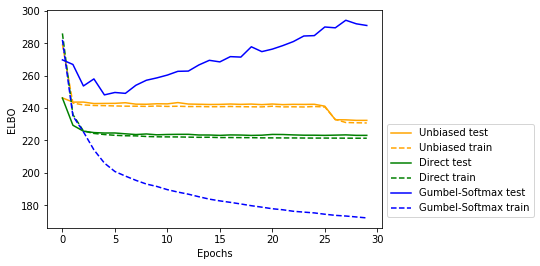

In [17]:

utils.show_and_save_plots([[(tr_unb,te_unb),'Unbiased'],
                           [(tr_dr,te_dr),'Direct'],
                           [(tr_gsm,te_gsm),'Gumbel-Softmax']])

#### Insights:

- The analytical approach is worse than the other two reparameterization approaches (at least in this specific experiment). It is well-known that REINFORCE suffers from high variance and hence converges very slowly. However, we see that even when computing the summation without sampling, the performance is worse than the reparameterization techniques.


- The Gumbel-Softmax estimator relaxes the discrete variable during training, which explains the big gap between the train and test curves.


- The train and test curves of Direct-Gumbel-Max are close to each other throughout the training, which may indicate good generalization and stability.

## Generating images

Let's generate images with the trained models and see if we can tell the differences. Each model generates $k$ images, one for each discrete class.

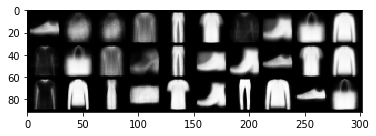

In [18]:
onehots = torch.eye(K) # K one-hot vectors

out_unbiased = torch.sigmoid(decoder_unbiased(onehots)).view(-1,1,28,28)
out_direct = torch.sigmoid(decoder_direct(onehots)).view(-1,1,28,28)
out_gsm = torch.sigmoid(decoder_gsm(onehots)).view(-1,1,28,28)
out = torch.cat((out_unbiased,out_direct,out_gsm))

out=torchvision.utils.make_grid(out,nrow=K)
utils.show(out)


### &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;   Decoder evaluations

|&nbsp;|&emsp; &emsp; &emsp;   unbiased  &emsp; &emsp; &emsp; |&emsp; &emsp; &emsp; direct  &emsp; &emsp; &emsp;|&emsp; &emsp; &emsp; GSM &emsp; &emsp; &emsp;|
|:---:|:---:|:---:|:---:|
|**forward**|&emsp; &emsp; &emsp;  $k$ &emsp; &emsp; &emsp;| &emsp; &emsp; &emsp; $k+1$ &emsp; &emsp; &emsp;| &emsp; &emsp; &emsp; $1$  &emsp; &emsp; &emsp;|
|**backward**| &emsp; &emsp; &emsp; $k$  &emsp; &emsp; &emsp;| &emsp; &emsp; &emsp; $1$  &emsp; &emsp; &emsp;| &emsp; &emsp; &emsp; $1$  &emsp; &emsp; &emsp;|
    
The table shows the number of the decoder evaluations (per one sample). For cells that are valued at >1, the evaluations are computed in batches. For the forward/direct cell, $1$ is for the forward pass and $k$ is for the decoder evaluations that needed in order to compute the encoder gradients. These $k$ evaluations are offline in the sense that there is no need to store their gradients for backward pass.



### &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; Encoder operations
|&nbsp;|&emsp; &emsp; &emsp; unbiased &emsp; &emsp; &emsp;|&emsp; &emsp; &emsp; direct &emsp; &emsp; &emsp;| &emsp; &emsp; &emsp; GSM &emsp; &emsp; &emsp;|
|:---:|:---:|:---:|:---:|
|**forward**|  $k$ (*Softmax* operation)  |  $k$ (*max* operation) |  $k$ (*Softmax* operation)  |
|**backward**|  $k$ (chain rule) |  $2$ (opt, direct) |  $k$ (chain rule)|

In this table, we present the number of operations required to compute $h(x)$. In case the encoder is unstructured, the *max* and *Softmax* operations have the same complexity. However, when the encoder is structured, the number of different assignments can grow exponentially, and the *max* operation can be computed with much better complexity than *Softmax*.





# High dimensional latent space
--------------------------

So far, we have discussed the case where $z$ is a single discrete latent variable. We're now moving to a high dimensional latent space where $z = (z_1,...,z_n)$.
In this case, the decoder is structured:
$$ f_\theta (x,z_1,...,z_n) $$

## Unstructured encoder:

<img style="float: right;" src="figs/high-dim_dvae.png" width="220" height="50">
The unstructured encoder gets $x$ as input and produces $n$ discrete variables:
$$ h_\phi(x,z) = \sum_i h_{\phi_i}(x, z_i) $$

In this case, in order to optimize the summation, we can optimize each dimension separately. 

$$ z_{i}^{opt} = \arg \max_{z_i} \{h_{\phi_i}(x, z_i) + \gamma_i(z_i)\} \\ $$ 

However, in order to find $z^{direct}$, we need to enumerate over all possible assignments of $(z_1,...,z_n)$ and evaluate $f_\theta$ to find the $\arg\max$.

<img style="float: left;" src="figs/OMG.png" width="30" height="30">
$$ z^{direct} = \arg \max_{z_1,...,z_n} \{\epsilon f_\theta(z_1,...,z_n) + \sum_{i=1}^n h_{\phi_i}(x, z_i) + \sum_{i=1}^n \gamma_i(z_i)\}$$

Therefore, we evaluate and maximize $f_\theta$ for each dimension separately, while the rest of the dimensions are fixed.

<img style="float: left;" src="figs/Smiling.png" width="30" height="30">
$$ z_{i}^{direct}(\epsilon) \approx \arg \max_{z_i} \{\epsilon f_\theta(z_{1}^{opt},...,z_{i},...,z_{n}^{opt}) + h_i(x, z_i) + \gamma_i(z_i)\}$$



## Structured encoder:
In the unstructured case above, both Softmax and argmax operations have roughly the same running time complexity. 

<img style="float: right;" src="figs/structured_dvae.png" width="200" height="40">
However, when $z$ is structured, solving a Softmax operation can be very hard and sometimes impossible, because of the exponential assignments in the partition function $\sum_{\hat z \in \mathcal{Z}} e^{h(x,\hat z)}$. 

We were working on a structure of the form:
$$ h_\phi(x,z) = \sum_{i=1}^n h_i(x,z_i;\phi) + \sum_{i > j} h_{i,j}(x,z_i,z_j;\phi)$$

In order to compute Softmax operation of the energy function above, one should compute all possible assignments ($2^n$). It is a very painful process.
Instead, solving $\arg\max$ problems can be obtained by ILP solvers, such as *CPLEX* or *max-flow*.


*max-flow* can deal only with positive potentials $h_{i,j}(x,z_i,z_j)$
*CPLEX* can solve any (positive and negative) $h_{i,j}(x,z_i,z_j)$ and by that the encoder captures positive and negative interactions between variables. However, it comes with the price of much longer wall-clock time.

By two such maximizations, we can  get $z_{opt} \text{ and } z_{direct}$ and by that to estimate the encoder gradients with reasonable time complexity. Unfortunately, the ILP solvers don't support batch-wise computations, so we need to loop over the batch samples. One definitely can optimize the code with parallel threads.


#### more details:
The encoder $h_\phi(x,z)$ produces $2\cdot n + {n \choose2}$ output units. 

$2\cdot n$ : $n$ binary variables as one-hot representation ($h_i$).

${n \choose2}$: interactions between pairs of variables ($h_{ij}$).

In order to solve the maximization problem via the maxflow algorithm, we need to force $h_{ij} \geq 0$, which we do by the softplus operation. 


In [19]:
class Structrued_Encoder(nn.Module):
    
    def __init__(self, x_dim=784, N=6,solver='maxflow'):
        super(Structrued_Encoder, self).__init__()
        self.all_pairs = utils.ncr(N,2)
        self.encoder = nn.Sequential(
            nn.Linear(x_dim,300),
            nn.ReLU(),
            nn.Linear(300,2*N + self.all_pairs))
        self.N = N
        self.solver=solver
        
    def forward(self, x):
        h_x = self.encoder(x)
        h_i, h_ij = h_x.split([2*self.N,self.all_pairs],dim=1)
        if self.solver=='maxflow':
            h_ij = F.softplus(h_ij) # force h_ij >= 0
        z,h_gamma = self.gumbel_perturbation(h_i,h_ij)
        return z,h_gamma

    
    def gumbel_perturbation(self,h_i,h_ij):
        """ Pertubes N binary variables and solves the argmax of the pairwise energy function.
            args:
                h_i: N potentials 
                h_ij: N choose 2 potentials
            returns:
                z: N binary variables
                h: pertubed h_i and h_ij potentials """
                
        h_i = h_i.contiguous().view(-1,2)

        gumbel_noise = utils.sample_gumbel(h_i,standard_gumbel=True)
        h_i_gamma = h_i + gumbel_noise
        h =list(zip(h_i_gamma.view(-1,self.N,2),h_ij))
        if self.solver=='maxflow':
            z = utils.argmax_maxflow(h)
        elif self.solver=='cplex':
            z = utils.argmax_cplex(h)
        else: # none
            z = h_i_gamma.argmax(-1).view(-1,self.N)

        return z, h



However, $z_{direct}$ requires enumerating over $f_\theta(x,z_i)$, which is also exponential. Therefore, we search for $z_{direct}$ in a sub-space. Here we have $n$ binary variables and the way we search for $z_{direct}$ is to start from the realization of $z_{opt}$ and to change one variable at a time, while the rest are fixed.

I tried to keep the code here as clean and readable as possible. Therefore, for a deeper understanding see *blog_utils.py*. 

In [20]:

def compute_structured_encoder_gradients(z_opt,h_gamma,ground_truth,models,epsilon=1.0):
    """Direct optimization gradient for structured latent space models. 
    args: 
        z_opt: binary vector of size N 
        h_gamma: h_i, h_ij pertubed potentials
        ground_truth: the images x
        models: encoder and decoder 
        epsilon: hyper-parameter of direct optimization
    returns:
        encoder gradients (after .backward()) """
    
    h_i,h_ij = zip(*h_gamma)    
    h_i = torch.cat(h_i)
    encoder,decoder=models
    N = encoder.N
    K = 2
    z_hat = utils.z_hat(z_opt,h_i,N,K)
    gt_batch = ground_truth.repeat_interleave(N*K,0)

    decoder.eval()
    f_tilda = decoder(z_hat)
    with torch.no_grad():
        f_tilda = F.binary_cross_entropy_with_logits(f_tilda,gt_batch,reduction='none').sum(-1)

    grad_h_i,grad_h_ij = utils.h_i_and_h_ij_grads(h_i,h_ij,f_tilda,z_opt,epsilon,encoder.solver)
    
    gradients = torch.cat((grad_h_i, grad_h_ij),-1)
    decoder.train()
    gradients = gradients*(1.0/epsilon)
    return torch.sum(gradients)

In [21]:
def train_high_dimensional(train_loader,models,optimizers):
    """train two discrete high-dimensional VAEs, one for unstructured and the other for structured. 
    args:
        train_loader: PyTorch train loader
        models:  unstructured and structured encoder and decoder
        optimizers: PyTorch ADAM optimizers for each model
    returns:
        elbo: average loss over the train-set for each model """
    
    elbo_structured, elbo_unstructured = 0,0
    eps_0,ANNEAL_RATE,min_eps = 1.0, 1e-5,0.1
    for i, (x, _) in enumerate(train_loader):
        batch_size = x.size(0)
        x = x.view(batch_size, -1).round()
        
        for m,(models_,optimizers_) in enumerate(zip(models,optimizers)):
            encoder,decoder = models_
            encoder_opt,decoder_opt = optimizers_
        

            # forward
            z,h_gamma = encoder(x)

            N=encoder.N
            out = decoder(F.one_hot(z,2).view(-1,N*2).float()) 
            # backward
            encoder_loss = compute_structured_encoder_gradients(z,h_gamma,x,models_)
            decoder_loss  = F.binary_cross_entropy_with_logits(out,x,reduction='none').sum()

            h_i,h_ij = zip(*h_gamma)
            kl = utils.kl_multinomial(torch.cat(h_i).view(-1,2))
            
            encoder_opt.zero_grad()
            decoder_opt.zero_grad()

            decoder_loss.backward()
            encoder_loss.backward()

            decoder_opt.step()
            encoder_opt.step()
            
            
            elbo = ((decoder_loss+kl)/batch_size).detach().item()
            if m == 0:
                elbo_unstructured += elbo
            elif m == 1:
                elbo_structured += elbo

    elbo_unstructured = elbo_unstructured/len(train_loader)
    elbo_structured = elbo_structured/len(train_loader)
    return elbo_unstructured, elbo_structured

In [22]:
def evaluate_high_dimensional(test_loader,models):
    """evaluate the structured and unstructured models over test-set. 
    args:
        test_loader: PyTorch test loader
        models:  unstructured and structured encoder and decoder
    returns:
        elbo: average loss over the test-set for each model """
    [m.eval() for model in models for m in model]
    elbo_structure, elbo_unstructure = 0,0
    with torch.no_grad():
        for x, _ in test_loader:        
            x = x.view(x.size(0), -1).round()
            bs = x.size(0)
            
            for i,models_ in enumerate(models):
                encoder,decoder=models_
                # forward
                z,h_gamma = encoder(x)
                N=encoder.N

                out = decoder(F.one_hot(z,2).view(-1,N*2).float()) 
                # backward
                encoder_loss = compute_structured_encoder_gradients(z,h_gamma,x,models_)

                decoder_loss  = F.binary_cross_entropy_with_logits(out,x,reduction='none').sum()
                h_i,h_ij = zip(*h_gamma)
                kl = utils.kl_multinomial(torch.cat(h_i).view(-1,2))
                elbo = ((decoder_loss+kl)/bs).detach().item()

                if i == 0:             
                    elbo_unstructure += elbo
                elif i == 1:
                    elbo_structure += elbo               

    [m.train() for model in models for m in model]

    elbo_unstructure = elbo_unstructure/len(test_loader)
    elbo_structure = elbo_structure/len(test_loader)
    return elbo_unstructure, elbo_structure

### Training procedure:

Let's compare the structured encoder to the unstructured encoder. 
We can set the 'solver' attribute to 'maxflow', 'cplex' or 'none', where 'none' is unstructured.



In [23]:

n=15 # number of binary latent space variables

###### Unstructured encoder ########
unstrc_encoder = Structrued_Encoder(N=n,solver='none')
unstrc_decoder = Decoder(x_dim=x_dim,K=2*n)
unstrc_models = unstrc_encoder,unstrc_decoder

opt_enc_unstrc = torch.optim.Adam(unstrc_encoder.parameters(), lr=0.001)
opt_dec_unstrc = torch.optim.Adam(unstrc_decoder.parameters(), lr=0.001)

models_unstrc = unstrc_encoder, unstrc_decoder
opt_unstrc = opt_enc_unstrc, opt_dec_unstrc

###### Structured encoder ########
strc_encoder = Structrued_Encoder(N=n,solver='maxflow')
strc_decoder = Decoder(x_dim=x_dim,K=2*n)
strc_models = strc_encoder, strc_decoder
opt_enc_strc = torch.optim.Adam(strc_encoder.parameters(), lr=0.001)
opt_dec_strc = torch.optim.Adam(strc_decoder.parameters(), lr=0.001)

models_strc = strc_encoder,strc_decoder
opt_strc = opt_enc_strc,opt_dec_strc


models = [models_unstrc,models_strc]
optimizers = [opt_unstrc, opt_strc]
strc_elbo,unstrc_elbo=[],[]
for t in range(30):
    train_unstrc, train_strc = train_high_dimensional(train_loader,models,optimizers)
    eval_unstrc, eval_strc = evaluate_high_dimensional(test_loader,models)
    
    unstrc_elbo.append((train_unstrc,eval_unstrc))
    strc_elbo.append((train_strc,eval_strc))
    
    
    print ('unstructured: {:.2f}, structured: {:.2f}'.format(eval_unstrc,eval_strc))



unstructured: 227.55, structured: 230.43
unstructured: 214.25, structured: 213.09
unstructured: 210.81, structured: 207.72
unstructured: 205.33, structured: 206.53
unstructured: 201.71, structured: 200.92
unstructured: 200.71, structured: 197.54
unstructured: 194.23, structured: 191.57
unstructured: 191.34, structured: 187.97
unstructured: 191.69, structured: 184.40
unstructured: 189.05, structured: 179.58
unstructured: 188.03, structured: 177.63
unstructured: 185.81, structured: 174.65
unstructured: 186.44, structured: 172.32
unstructured: 184.50, structured: 171.72
unstructured: 182.53, structured: 169.75
unstructured: 180.37, structured: 168.86
unstructured: 179.08, structured: 166.95
unstructured: 179.57, structured: 166.75
unstructured: 178.31, structured: 165.70
unstructured: 177.62, structured: 164.50
unstructured: 176.33, structured: 163.75
unstructured: 175.85, structured: 163.31
unstructured: 175.97, structured: 162.70
unstructured: 175.15, structured: 161.76
unstructured: 17

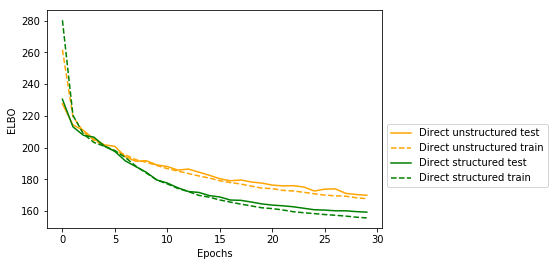

In [24]:
tr_str,te_str=zip(*strc_elbo)
tr_unstr,te_unstr=zip(*unstrc_elbo)
utils.show_and_save_plots([[(tr_unstr,te_unstr),'Direct unstructured'],
                           [(tr_str,te_str),'Direct structured']])

## Generating images

Here we draw $10$ samples of $n$ binary vectors and generate images, by using the two trained models.
Note, that the latent space size is $2^n$, so we can't visualize the entire space as we did in the 1-dimensional case. 

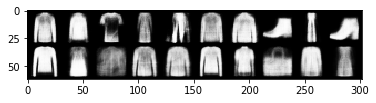

In [25]:
z=torch.tensor([np.random.choice([0, 1], size=(n,), p=[1./2, 1./2]) for _ in range(10)])
z=F.one_hot(z).float().view(z.size(0),-1)
out_strc = torch.sigmoid(strc_decoder(z)).view(-1,1,28,28)
out_unst = torch.sigmoid(unstrc_decoder(z)).view(-1,1,28,28)

to_show = torch.cat((out_strc,out_unst))
out_strc=torchvision.utils.make_grid(to_show,nrow=10)
utils.show(out_strc)



### &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;  Decoder evaluations

|&nbsp;|&emsp; &emsp; &emsp;   unbiased  &emsp; &emsp; &emsp; |&emsp; &emsp; &emsp; direct &emsp; &emsp; &emsp; &emsp; &emsp;|&emsp; &emsp; &emsp; GSM &emsp; &emsp; &emsp;&emsp; &emsp;|
|:---:|:---:|:---:|:---:|
|**forward**|  &emsp; $2^n$ &emsp; &emsp; &emsp; &emsp; |&emsp; &emsp;  $n+1$ (input size: $n + {n\choose 2}$) &emsp; &emsp;| &emsp; &emsp; &emsp; $1$ (input size: $2^n$)  &emsp; &emsp; &emsp;|
|**backward**| &emsp; $2^n$  &emsp; &emsp; &emsp;  &emsp;  |&emsp;  $ 1 $ &emsp; &emsp; &emsp;  &emsp; &emsp; &emsp; | &emsp; &emsp; &emsp; $1$ (input size: $2^n$) &emsp; &emsp; &emsp; |
    
*Gumbel-Softmax* is an end-to-end approach, which is a major advantage. However, in order to compute *Softmax*, one should evaluate $h_\phi(x,z)$ for all $z$ realizations which makes it unfeasible (for about $n \ge 15$).

In *Direct-Gumbel-Max*, we look for the *$\arg\max$* that can be found more efficiently than *Softmax*. However, we need to search for $z_{direct}$ in an exponential space. Instead, we search in a sub-space. In forward/direct cell, $1$ is for the forward pass and $n$ for the forward pass, when computing $z_{direct}$. These $n$ evaluations are offline in a sense that there is no need to store their gradients for backward pass.


### &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;  Encoder operations

|&nbsp;|&emsp; &emsp; &emsp;   unbiased  &emsp; &emsp;&emsp; &emsp; &emsp; |&emsp; &emsp; direct  &emsp;&emsp; &emsp; &emsp; &emsp;&emsp;&emsp;|&emsp; &emsp; &emsp; GSM &emsp; &emsp; &emsp;&emsp; &emsp;|
|:---:|:---:|:---:|:---:|
|**forward**| &emsp; &emsp; $2^n$ (*softmax* operation) &emsp; &emsp;  |ILP solver complexity  &emsp; &emsp;&emsp; &emsp;| &emsp; &emsp; $2^n$ (*softmax* operation) &emsp; &emsp; |
|**backward**|  $2^n$ (chain rule) &emsp; &emsp;&emsp; &emsp;| &emsp; &emsp; $2 \times$ solver complexity (opt, direct) &emsp; &emsp;  |$2^n$ (chain rule) &emsp; &emsp;&emsp; &emsp;|


# Mixture model (semi-supervised)
-----------------------------------

<img  style="float: right;" src="figs/mixture_model_dvae.png" width="220" height="50">
A natural extension to the discrete VAE, is to model a latent space that can capture both discrete and continuous features. The idea is that each discrete class will be associated with a multivariate gaussian variable. For example, the MNIST dataset has 10 discrete classes (0-9 digits), where each of the class digits have continuous features, such as: bold, thick, italic, big or small etc.

The encoder is composed of three parts:

- shared encoder $h_\phi$
- discrete encoder $h_\phi^d$
- continuous encoder $h_\phi^c$

We sample from the discrete and continuous posterior, using Gumbel-max and standard Gaussian reparameterization respectively. We then multiply them to create the input for the decoder. We can use a matrix multiplication between one-hot vector (discrete class) and the Gaussian matrix (one row for each discrete class) in order to extract the Gaussian feature vector of the i'th discrete class. However, the decoder will not be able to distinguish between the different classes, so we want to pass the decoder information on which row the Gaussian vector is taken. We do this by keeping the zeros after multiplication:

$(0,1,0,0) \cdot \begin{pmatrix}1 & 2 & 3\\
4 & 5 & 6\\
7 & 8 & 9\\
10 & 11 & 12
\end{pmatrix} = (0,0,0,4,5,6,0,0,0,0,0,0)$



In [26]:
class Mixture_Encoder(nn.Module):
    
    def __init__(self, x_dim=784, N=6, hidden=400, gauss_dim = 10 ):
        super(Mixture_Encoder, self).__init__()
        self.shared_encoder = nn.Sequential(
            nn.Linear(x_dim,600),
            nn.LeakyReLU(0.2),
            nn.Linear(600,hidden))
        
        self.discrete_encoder = nn.Sequential(
            nn.Linear(hidden,hidden//2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden//2,N)) 
        
        self.gaussian_encoder = nn.Sequential(
            nn.Linear(hidden,N*(hidden//10)),
            nn.LeakyReLU(0.2))     
        
        self.N_gaussians = nn.Sequential(
            nn.Linear(hidden//10,hidden//10),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.5),
            nn.Linear(hidden//10,2*gauss_dim))
        
        self.gauss_dim = gauss_dim
        self.N = N

        
    def forward(self, x):
        x = self.shared_encoder(x)
        self.discrete_logits = self.discrete_encoder(x)
        gaussian = self.gaussian_encoder(x).view(x.size(0)*self.N,-1)
        
        self.z_discrete,self.mean_onehot = self.gumbel_perturbation(self.discrete_logits)
        self.z_gauss, mu, logvar = self.gaussian_perturbation(gaussian)
        
        self.compute_kl(mu, logvar)
        z = torch.einsum('bij,bjk->bjk',self.mean_onehot, self.z_gauss).view(x.size(0),-1)
        
        return z
    
    def gumbel_perturbation(self,discrete_logits):
        """reparametrization of a discrete variable (Gibbs)"""
        discrete_logits = discrete_logits.repeat_interleave(1,0)
        self.logits_gumbel = utils.sample_gumbel(discrete_logits)
        argmax = self.logits_gumbel.argmax(-1)
        onehot = F.one_hot(argmax,self.N).float().view(-1,1,self.N)
        
        z_discrete = onehot[:,0,:].unsqueeze(1)
        mean_onehot = onehot.mean(1).unsqueeze(1)
        return z_discrete, mean_onehot
        
    def gaussian_perturbation(self,z):
        """reparametrization of a continuous variable (Gaussian)"""
        z = self.N_gaussians(z)
        mu,logvar = torch.chunk(z, chunks = 2, dim=1)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        q_z =(mu + eps*std).view(-1,self.N,self.gauss_dim)
        return q_z,mu,logvar

    def compute_discrete_encoder_gradients(self, ground_truth, decoder, labels=None, epsilon=0.1):
        """ Direct optimization function
        args:
            ground_truth: images
            decoder: the decoder network, for computing z_direct
            labels: labels for the discrete encoder for (semi-)supervised learning.
                    If None: unsupervised clustering
        returns:
            encoder loss"""
        shape = self.z_discrete.size()
        batch_size = shape[0]
        N = shape[-1]
        z_hat = torch.zeros(batch_size,N,N)
        z_hat[:] = torch.eye(N) # z_1,...,z_n (1-hot)
        z_discrete = z_hat.view(batch_size*N,-1).unsqueeze(1)
        z_gauss = self.z_gauss.repeat_interleave(N,0)
        new_batch = torch.einsum('bij,bjk->bjk', z_discrete, z_gauss).view(-1,N*z_gauss.size(-1))
        gt_batch = ground_truth.repeat_interleave(N,0)
        with torch.no_grad():
            out = decoder(new_batch.view(-1,N * z_gauss.size(-1)))
            f_theta = F.binary_cross_entropy_with_logits(out,gt_batch,reduction='none')
            f_theta = f_theta.view(out.size(0),-1).sum(-1)
            direct_objective = self.logits_gumbel - epsilon*f_theta.view_as(self.logits_gumbel)
        argmax = direct_objective.argmax(-1)
        if labels is not None:
            argmax = labels
        z_direct = F.one_hot(argmax,num_classes=N).float()
        gradients_sign = self.z_discrete.squeeze(1) - z_direct
        gradients_sign = gradients_sign*(1.0/epsilon)
        
        return torch.sum(gradients_sign*self.discrete_logits)
    
    def compute_kl(self, mues, logvar):

        mu = torch.bmm(self.z_discrete,mues.view(-1,self.N,self.gauss_dim)).view(-1,self.gauss_dim)
        logvar = torch.bmm(self.z_discrete,logvar.view(-1,self.N,self.gauss_dim)).view(-1,self.gauss_dim)
        
        self.kl_gauss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        self.kl_gibbs = utils.kl_multinomial(self.discrete_logits)


In [27]:
def train_mixture(train_loader):
    """train with Direct-Gumbel-Max
    args:
        x: batch of images
    returns:
        elbo: average loss over batch of samples """
    mean_elbo = 0
    for i, (x, y) in enumerate(train_loader):
        batch_size=x.size(0)
        x = x.view(batch_size, -1).round()
        
        z = encoder(x)
        out = decoder(z)

        kl_continuous = encoder.kl_gauss
        kl_discrete = encoder.kl_gibbs
        
        encoder_loss = encoder.compute_discrete_encoder_gradients(x,decoder,y)
        decoder_loss  = F.binary_cross_entropy_with_logits(out, x,reduction='sum')
        
        loss = decoder_loss + kl_continuous + encoder_loss
        
        optimizer.zero_grad()        
        loss.backward()
        optimizer.step()
        
        elbo = ((decoder_loss + kl_discrete + kl_continuous)/batch_size).detach().item()
        mean_elbo += elbo
        
    mean_elbo = mean_elbo/len(train_loader)    
    return mean_elbo

In [28]:
def evaluate_mixture(test_loader):
    """train with Direct-Gumbel-Max
    args:
        x: batch of images
    returns:
        elbo: average loss over batch of samples """
    encoder.eval()
    decoder.eval()
    mean_elbo = 0
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            batch_size=x.size(0)
            x = x.view(batch_size, -1).round()
            
            z = encoder(x)
            out = decoder(z.view(batch_size,-1))

            kl_continuous = encoder.kl_gauss
            kl_discrete = encoder.kl_gibbs

            decoder_loss  = F.binary_cross_entropy_with_logits(out, x, reduction='sum')

            elbo = ((decoder_loss + kl_continuous + kl_discrete)/batch_size).detach().item()
            mean_elbo += elbo
            
    encoder.train()
    decoder.train()        
    mean_elbo = mean_elbo/len(test_loader)    
    return mean_elbo

### Training procedure:
We can now train the mixture model. All we have changed is the encoder, while the decoder is the same decoder it was in the previous sections.

In [29]:
n = 10
gauss_dim = 20
batch_size=100


train_loader,test_loader=utils.get_data(batch_size, dataset = 'fashion-mnist')
encoder = Mixture_Encoder(N=n,gauss_dim=gauss_dim)
decoder = Decoder(x_dim=x_dim,K=gauss_dim*n) 

print(encoder)
print(decoder)
optimizer = torch.optim.Adam(list(encoder.parameters()) + 
                             list(decoder.parameters()), lr=0.0008)

Mixture_Encoder(
  (shared_encoder): Sequential(
    (0): Linear(in_features=784, out_features=600, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=600, out_features=400, bias=True)
  )
  (discrete_encoder): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=200, out_features=10, bias=True)
  )
  (gaussian_encoder): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (N_gaussians): Sequential(
    (0): Linear(in_features=40, out_features=40, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.5)
    (3): Linear(in_features=40, out_features=40, bias=True)
  )
)
Decoder(
  (f): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=784, bias=True)
  )
)


In [30]:
loss_direct = []
for epoch in range(15):
    train_elbo = train_mixture(train_loader)
    test_elbo = evaluate_mixture(test_loader)  
    loss_direct.append((train_elbo,test_elbo))
    print('epoch {}:  train loss: {:.2f}, test loss: {:.2f}'.format(epoch,train_elbo,test_elbo))

tr,te = zip(*loss_direct)


epoch 0:  train loss: 246.92, test loss: 192.10
epoch 1:  train loss: 192.31, test loss: 177.75
epoch 2:  train loss: 182.97, test loss: 172.79
epoch 3:  train loss: 177.54, test loss: 165.57
epoch 4:  train loss: 173.43, test loss: 164.21
epoch 5:  train loss: 170.48, test loss: 160.43
epoch 6:  train loss: 168.28, test loss: 157.67
epoch 7:  train loss: 166.10, test loss: 155.80
epoch 8:  train loss: 164.35, test loss: 154.26
epoch 9:  train loss: 162.89, test loss: 153.99
epoch 10:  train loss: 161.52, test loss: 151.73
epoch 11:  train loss: 160.13, test loss: 149.84
epoch 12:  train loss: 158.68, test loss: 148.25
epoch 13:  train loss: 157.22, test loss: 148.23
epoch 14:  train loss: 156.21, test loss: 146.05


## Generate images:
We will now generate images using the trained model. The images in each row are generated out of the same Gaussian variable and the columns are the Fashion-MNIST classes.  

torch.Size([100, 10, 20])


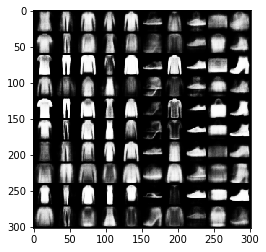

In [31]:
onehots = torch.zeros(10,n,n)
onehots[:] = torch.eye(n) # n one-hot vectors
onehots = onehots.view(-1,n).unsqueeze(1)
gauss = torch.randn(10,1,gauss_dim).repeat_interleave(10,1).repeat_interleave(10,0)
z=torch.einsum('bij,bjk->bjk', onehots, gauss).view(-1,n*gauss_dim)
out = torch.sigmoid(decoder(z)).view(-1,1,28,28)
out=torchvision.utils.make_grid(out,nrow=n)
utils.show(out)

## Conclusion

Gumbel-Max trick with Direct-Optimization is a promising direction for research, especially for high-dimensional  and structured problems. A natural application that can be optimized via Direct-Gumbel-max is reinforcement learning, since the optimization is over high-dimensional discrete actions [8]. 

# References

[1] Diederik P Kingma, Max Welling. “Auto-Encoding Variational Bayes.” ICLR, 2014.

[2] Chris J. Maddison, Andriy Mnih, and Yee Whye Teh. “The Concrete Distribution: a Continuous Relaxation of Discrete Random Variables.” ICLR, 2017.

[3] Eric Jang, Shixiang Gu and Ben Poole. “Categorical Reparameterization by Gumbel-Softmax.” ICLR, 2017.

[4] D.McAllester, T. Hazan, and J. Keshet. "Direct loss minimization for structured prediction." NIPS, 2010.

[5] Y. Song, A. G. Schwing, R. Zemel, and R. Urtasun. "Training Deep Neural Networks via DirectLoss Minimization." ICML, 2016.

[6] Danilo Jimenez Rezende, Shakir Mohamed, and Daan Wierstra. "Stochastic backpropagationand approximate inference in deep generative models." ICML, 2014.

[7] Jordan, M.I. and Ghahramani, Z. and Jaakkola, T.S. and Saul, L.K. "An introduction to variational methods for graphical models." 

[8] G.Lorberbom, C.J. Maddison, N.Heess, T.Hazan, D.Tarlow "Direct Policy Gradients: Direct Optimization of Policies in Discrete Action Spaces."

